In [ ]:
import torch, torchvision, platform
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("cuda:", torch.version.cuda, "| python:", platform.python_version())

!pip install -q scikit-learn pandas numpy pillow torchvision
!pip install -q timm==0.9.2
!pip install -q segmentation-models-pytorch==0.3.3 --no-deps
!pip install -q albumentations==1.4.3 opencv-python "torchmetrics>=1.2.0"
!pip install -q pretrainedmodels==0.7.4 efficientnet-pytorch==0.7.1


torch: 2.9.0+cu126
torchvision: 0.24.0+cu126
cuda: 12.6 | python: 3.12.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

DRIVE_ROOT   = "/content/drive/MyDrive"
PROJECT_ROOT = os.path.join(DRIVE_ROOT, "TongueImagediabetes/data")

# 1) Original segmentation dataset (images + masks)
SEG_IMG_DIR  = os.path.join(PROJECT_ROOT, "tongue data", "image")
SEG_MASK_DIR = os.path.join(PROJECT_ROOT, "tongue data", "label")

# 2) Where to save segmentation checkpoints & logs
SEG_RUN_DIR   = os.path.join(PROJECT_ROOT, "segmentation_runs")
SEG_CKPT_PATH = os.path.join(SEG_RUN_DIR, "tongue_unetpp_effb3_best.pt")

"""# 3) Where to save final preprocessed tongue images"""
"""PREPROC_ROOT = os.path.join(PROJECT_ROOT, "preprocessed_from_segmentation_only")"""

os.makedirs(SEG_RUN_DIR,  exist_ok=True)
#os.makedirs(PREPROC_ROOT, exist_ok=True)

print("SEG_IMG_DIR :", SEG_IMG_DIR)
print("SEG_MASK_DIR:", SEG_MASK_DIR)
print("SEG_RUN_DIR :", SEG_RUN_DIR)
#print("PREPROC_ROOT:", PREPROC_ROOT)

SEG_IMG_DIR : /content/drive/MyDrive/TongueImagediabetes/data/tongue data/image
SEG_MASK_DIR: /content/drive/MyDrive/TongueImagediabetes/data/tongue data/label
SEG_RUN_DIR : /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs


In [ ]:
# ==== Segmentation Step 1: Dataset for (image, mask) pairs ====
import glob
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

SEG_SIZE = 512  # training/inference size for the seg model

class TongueSegDataset(Dataset):
    """
    Dataset for tongue segmentation:
    - Reads images from SEG_IMG_DIR
    - For each image <name>.png/jpg there must be a mask with the same filename in SEG_MASK_DIR
    """
    def __init__(self, img_dir, mask_dir, size=SEG_SIZE, augment=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size

        # collect image paths
        exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
        img_paths = []
        for e in exts:
            img_paths.extend(glob.glob(os.path.join(img_dir, e)))
        img_paths = sorted(img_paths)

        self.samples = []
        for ip in img_paths:
            base = os.path.basename(ip)
            mp = os.path.join(mask_dir, base)
            if os.path.exists(mp):
                self.samples.append((ip, mp))
        print(f"Found {len(self.samples)} image+mask pairs")

        if augment:
            self.transform = A.Compose(
                [
                    A.LongestMaxSize(max_size=size),
                    A.PadIfNeeded(size, size, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, position="center"),
                    A.HorizontalFlip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10,
                                       border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),
                    A.RandomBrightnessContrast(p=0.3),
                    A.GaussianBlur(p=0.1),
                    A.Normalize(),
                    ToTensorV2()
                ]
            )
        else:
            self.transform = A.Compose(
                [
                    A.LongestMaxSize(max_size=size),
                    A.PadIfNeeded(size, size, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, position="center"),
                    A.Normalize(),
                    ToTensorV2()
                ]
            )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # Read image (BGR) and mask (grayscale)
        img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        mask    = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img_bgr is None:
            raise RuntimeError(f"Could not read image: {img_path}")
        if mask is None:
            raise RuntimeError(f"Could not read mask: {mask_path}")

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        mask01  = (mask > 127).astype("float32")  # binary 0/1

        augmented = self.transform(image=img_rgb, mask=mask01)
        img_t  = augmented["image"]   # [3,H,W]
        mask_t = augmented["mask"].unsqueeze(0)  # [1,H,W]

        return img_t, mask_t


In [ ]:
# ==== Segmentation Step 2: Train/val split & DataLoaders ====
from sklearn.model_selection import train_test_split

# First, build a dataset without augmentation just to count pairs
full_ds = TongueSegDataset(SEG_IMG_DIR, SEG_MASK_DIR, augment=False)

n = len(full_ds)
print("Total pairs:", n)

if n == 0:
    raise RuntimeError("No image+mask pairs found. Check SEG_IMG_DIR and SEG_MASK_DIR paths.")

# Indices for splitting
all_indices = np.arange(n)
train_idx, val_idx = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train size:", len(train_idx), "Val size:", len(val_idx))

# Now create real train/val datasets
train_ds = TongueSegDataset(SEG_IMG_DIR, SEG_MASK_DIR, augment=True)
val_ds   = TongueSegDataset(SEG_IMG_DIR, SEG_MASK_DIR, augment=False)

from torch.utils.data import Subset

train_ds = Subset(train_ds, train_idx)
val_ds   = Subset(val_ds,   val_idx)

BATCH_SIZE = 4

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=1,         shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders ready.")


Found 1261 image+mask pairs
Total pairs: 1261
Train size: 1008 Val size: 253
Found 1261 image+mask pairs
Found 1261 image+mask pairs
DataLoaders ready.


In [ ]:
# ==== Segmentation Step 3: Model & loss ====
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Unet++ with EfficientNet encoder (good balance of power/size)
model = smp.UnetPlusPlus(
    encoder_name="timm-efficientnet-b0",  # you can change to b0/b2 etc if needed
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)


class BCEDiceLoss(nn.Module):
    """
    Combines:
    - Binary Cross Entropy (per-pixel classification)
    - Dice loss (overlap)
    """
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        # logits, targets: [B,1,H,W]
        bce = F.binary_cross_entropy_with_logits(logits, targets)

        probs = torch.sigmoid(logits)
        smooth = 1.0
        intersection = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2.0 * intersection + smooth) / (union + smooth)
        dice_loss = 1.0 - dice.mean()

        return bce + dice_loss


criterion = BCEDiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


Using device: cuda
Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth


100%|██████████| 20.4M/20.4M [00:02<00:00, 8.03MB/s]


In [ ]:
# ==== Segmentation Step 4: Training loop with validation & checkpoint ====
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F

def eval_seg(model, loader, device="cuda"):
    """
    Evaluate segmentation model on a DataLoader.
    Returns: (mean_dice, mean_iou, mean_bce)
    """
    model.eval()
    dices, ious, bces = [], [], []
    bce_loss_fn = torch.nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for imgs, masks in loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)  # [B,1,H,W]

            logits = model(imgs)      # [B,1,H,W]
            probs  = torch.sigmoid(logits)
            preds  = (probs > 0.5).float()

            smooth = 1.0

            # ----- Dice (using binary preds) -----
            inter = (preds * masks).sum(dim=(2, 3))
            union = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3))
            dice  = (2.0 * inter + smooth) / (union + smooth)
            dices.extend(dice.squeeze(1).cpu().numpy().tolist())

            # ----- IoU (Jaccard) -----
            inter_iou = (preds * masks).sum(dim=(2, 3))
            union_iou = preds.sum(dim=(2, 3)) + masks.sum(dim=(2, 3)) - inter_iou
            iou = (inter_iou + smooth) / (union_iou + smooth)
            ious.extend(iou.squeeze(1).cpu().numpy().tolist())

            # ----- BCE (as a metric) -----
            bce = bce_loss_fn(logits, masks)
            bces.append(bce.item())

    mean_dice = float(np.mean(dices)) if dices else 0.0
    mean_iou  = float(np.mean(ious))  if ious  else 0.0
    mean_bce  = float(np.mean(bces))  if bces  else 0.0
    return mean_dice, mean_iou, mean_bce


EPOCHS   = 50
patience = 10      # early stopping patience

best_val_dice = -1.0
bad_epochs    = 0

history = {
    "train_loss": [],
    "val_dice":   [],
    "val_iou":    [],
    "val_bce":    [],
}

for epoch in range(1, EPOCHS + 1):
    # ---------- TRAIN ----------
    model.train()
    running_loss = 0.0
    n_batches    = 0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        imgs  = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, masks)  # your BCEDiceLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches    += 1

    train_loss = running_loss / max(1, n_batches)

    # ---------- VALIDATION ----------
    val_dice, val_iou, val_bce = eval_seg(model, val_loader, device=device)

    history["train_loss"].append(train_loss)
    history["val_dice"].append(val_dice)
    history["val_iou"].append(val_iou)
    history["val_bce"].append(val_bce)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"TrainLoss={train_loss:.4f} | "
        f"ValDice={val_dice:.4f} | "
        f"ValIoU={val_iou:.4f} | "
        f"ValBCE={val_bce:.4f}"
    )

    # ---------- CHECKPOINT / EARLY STOP ----------
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        bad_epochs = 0
        torch.save(model.state_dict(), SEG_CKPT_PATH)
        print(f"  -> New best model saved to {SEG_CKPT_PATH}")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping.")
            break

print("Best validation Dice:", best_val_dice)

Epoch 1/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 1/50 | TrainLoss=0.3769 | ValDice=0.9587 | ValIoU=0.9252 | ValBCE=0.0311
  -> New best model saved to /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


Epoch 2/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 2/50 | TrainLoss=0.0916 | ValDice=0.9685 | ValIoU=0.9431 | ValBCE=0.0292
  -> New best model saved to /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


Epoch 3/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 3/50 | TrainLoss=0.0774 | ValDice=0.9684 | ValIoU=0.9429 | ValBCE=0.0301


Epoch 4/50:   0%|          | 0/252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4/50 | TrainLoss=0.0733 | ValDice=0.9685 | ValIoU=0.9432 | ValBCE=0.0285


Epoch 5/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 5/50 | TrainLoss=0.0610 | ValDice=0.9709 | ValIoU=0.9476 | ValBCE=0.0291
  -> New best model saved to /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


Epoch 6/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 6/50 | TrainLoss=0.0611 | ValDice=0.9700 | ValIoU=0.9458 | ValBCE=0.0316


Epoch 7/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 7/50 | TrainLoss=0.0638 | ValDice=0.9707 | ValIoU=0.9472 | ValBCE=0.0291


Epoch 8/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 8/50 | TrainLoss=0.0578 | ValDice=0.9702 | ValIoU=0.9462 | ValBCE=0.0327


Epoch 9/50:   0%|          | 0/252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():^
^ ^ ^  ^ ^ ^ ^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^^
  ^^  ^^^^ ^ ^
   File "/usr/lib

Epoch 9/50 | TrainLoss=0.0622 | ValDice=0.9700 | ValIoU=0.9459 | ValBCE=0.0282


Epoch 10/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 10/50 | TrainLoss=0.0570 | ValDice=0.9715 | ValIoU=0.9486 | ValBCE=0.0301
  -> New best model saved to /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


Epoch 11/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 11/50 | TrainLoss=0.0554 | ValDice=0.9715 | ValIoU=0.9487 | ValBCE=0.0312
  -> New best model saved to /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


Epoch 12/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 12/50 | TrainLoss=0.0512 | ValDice=0.9712 | ValIoU=0.9482 | ValBCE=0.0287


Epoch 13/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 13/50 | TrainLoss=0.0540 | ValDice=0.9718 | ValIoU=0.9493 | ValBCE=0.0273
  -> New best model saved to /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


Epoch 14/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 14/50 | TrainLoss=0.0591 | ValDice=0.9658 | ValIoU=0.9378 | ValBCE=0.0291


Epoch 15/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 15/50 | TrainLoss=0.0565 | ValDice=0.9703 | ValIoU=0.9463 | ValBCE=0.0250


Epoch 16/50:   0%|          | 0/252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 16/50 | TrainLoss=0.0551 | ValDice=0.9715 | ValIoU=0.9487 | ValBCE=0.0257


Epoch 17/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 17/50 | TrainLoss=0.0506 | ValDice=0.9705 | ValIoU=0.9469 | ValBCE=0.0313


Epoch 18/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 18/50 | TrainLoss=0.0503 | ValDice=0.9696 | ValIoU=0.9453 | ValBCE=0.0269


Epoch 19/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 19/50 | TrainLoss=0.0490 | ValDice=0.9723 | ValIoU=0.9502 | ValBCE=0.0285
  -> New best model saved to /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


Epoch 20/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 20/50 | TrainLoss=0.0495 | ValDice=0.9717 | ValIoU=0.9492 | ValBCE=0.0274


Epoch 21/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 21/50 | TrainLoss=0.0560 | ValDice=0.9712 | ValIoU=0.9482 | ValBCE=0.0308


Epoch 22/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 22/50 | TrainLoss=0.0515 | ValDice=0.9715 | ValIoU=0.9488 | ValBCE=0.0299


Epoch 23/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 23/50 | TrainLoss=0.0505 | ValDice=0.9717 | ValIoU=0.9492 | ValBCE=0.0260


Epoch 24/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 24/50 | TrainLoss=0.0541 | ValDice=0.9659 | ValIoU=0.9383 | ValBCE=0.0295


Epoch 25/50:   0%|          | 0/252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>^^^
^^Traceback (most recent call last):
^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
            ^^if w.is_alive():^
 ^^^ ^^ ^^ ^^  ^ ^^^^^^^^^^^^

Epoch 25/50 | TrainLoss=0.0552 | ValDice=0.9721 | ValIoU=0.9499 | ValBCE=0.0294


Epoch 26/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 26/50 | TrainLoss=0.0545 | ValDice=0.9721 | ValIoU=0.9500 | ValBCE=0.0266


Epoch 27/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 27/50 | TrainLoss=0.0470 | ValDice=0.9728 | ValIoU=0.9512 | ValBCE=0.0278
  -> New best model saved to /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


Epoch 28/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 28/50 | TrainLoss=0.0503 | ValDice=0.9719 | ValIoU=0.9494 | ValBCE=0.0207


Epoch 29/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 29/50 | TrainLoss=0.0458 | ValDice=0.9722 | ValIoU=0.9501 | ValBCE=0.0300


Epoch 30/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 30/50 | TrainLoss=0.0464 | ValDice=0.9666 | ValIoU=0.9408 | ValBCE=0.0262


Epoch 31/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 31/50 | TrainLoss=0.0482 | ValDice=0.9727 | ValIoU=0.9510 | ValBCE=0.0276


Epoch 32/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 32/50 | TrainLoss=0.0456 | ValDice=0.9676 | ValIoU=0.9416 | ValBCE=0.0244


Epoch 33/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 33/50 | TrainLoss=0.0416 | ValDice=0.9583 | ValIoU=0.9324 | ValBCE=0.0361


Epoch 34/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 34/50 | TrainLoss=0.0566 | ValDice=0.9707 | ValIoU=0.9472 | ValBCE=0.0313


Epoch 35/50:   0%|          | 0/252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a18d7ffdf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 35/50 | TrainLoss=0.0500 | ValDice=0.9706 | ValIoU=0.9471 | ValBCE=0.0239


Epoch 36/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 36/50 | TrainLoss=0.0449 | ValDice=0.9724 | ValIoU=0.9504 | ValBCE=0.0256


Epoch 37/50:   0%|          | 0/252 [00:00<?, ?it/s]

Epoch 37/50 | TrainLoss=0.0470 | ValDice=0.9700 | ValIoU=0.9460 | ValBCE=0.0200
Early stopping.
Best validation Dice: 0.9728087710286583


In [ ]:
# ==== Preprocessing Step 1: reload best segmentation model for inference ====
import segmentation_models_pytorch as smp
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

SEG_SIZE = 512  # must match what you used in training

# Re-create the same Unet architecture as during training
infer_model = smp.UnetPlusPlus(
    encoder_name="timm-efficientnet-b0",
    encoder_weights=None,   # we will load our own weights
    in_channels=3,
    classes=1
).to(device)

infer_model.load_state_dict(torch.load(SEG_CKPT_PATH, map_location=device))
infer_model.eval()
print("Loaded checkpoint from:", SEG_CKPT_PATH)

# Albumentations transform: same geometry as training, but no randomness
infer_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=SEG_SIZE),
        A.PadIfNeeded(SEG_SIZE, SEG_SIZE, border_mode=cv2.BORDER_CONSTANT,
                      value=0, mask_value=0, position="center"),
        A.Normalize(),
        ToTensorV2()
    ]
)


Using device: cuda
Loaded checkpoint from: /content/drive/MyDrive/TongueImagediabetes/data/segmentation_runs/tongue_unetpp_effb3_best.pt


In [ ]:
# ==== Preprocessing Step 2: geometry + T2DM helpers ====
import numpy as np
import cv2

# --- letterbox helpers (for mapping mask back to original size) ---
def letterbox_params(orig_h, orig_w, size):
    scale = min(size / float(orig_h), size / float(orig_w))
    new_h = int(round(orig_h * scale))
    new_w = int(round(orig_w * scale))
    pad_h = size - new_h
    pad_w = size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return scale, (top, bottom, left, right), (new_h, new_w)

def mask_to_original(mask_512, orig_h, orig_w, size=512):
    """
    Remove padding from a 512x512 letterboxed mask and resize back to
    the original image shape (orig_h, orig_w). Returns a 0/1 float32 mask.
    """
    scale, (top, bottom, left, right), (new_h, new_w) = letterbox_params(orig_h, orig_w, size)

    h, w = mask_512.shape
    y0 = top
    y1 = h - bottom if bottom > 0 else h
    x0 = left
    x1 = w - right if right > 0 else w
    mask_cropped = mask_512[y0:y1, x0:x1]

    mask_resized = cv2.resize(mask_cropped, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
    mask_bin = (mask_resized > 0.5).astype("float32")
    return mask_bin

# --- gray-world white balance ---
def gray_world_white_balance(bgr: np.ndarray) -> np.ndarray:
    """
    Gray-world white balance: scale each channel so that its mean becomes
    the global gray level.
    """
    img = bgr.astype(np.float32)
    b, g, r = cv2.split(img)

    mean_b = b.mean()
    mean_g = g.mean()
    mean_r = r.mean()
    mean_gray = (mean_b + mean_g + mean_r) / 3.0 + 1e-6

    b *= mean_gray / (mean_b + 1e-6)
    g *= mean_gray / (mean_g + 1e-6)
    r *= mean_gray / (mean_r + 1e-6)

    wb = cv2.merge([b, g, r])
    wb = np.clip(wb, 0, 255).astype(np.uint8)
    return wb

In [ ]:
# --- main T2DM-oriented preprocessing ---
def preprocess_for_t2dm(orig_bgr: np.ndarray,
                        mask01: np.ndarray,
                        out_size: int = 224):
    """
    Post-segmentation preprocessing to emphasize T2DM-relevant features.

    Returns:
        tongue_img   : uint8 BGR image, out_size x out_size
        coating_u8   : uint8 single-channel, out_size x out_size (0/255)
        dist_u8      : uint8 single-channel distance map, out_size x out_size
        tex_u8       : uint8 single-channel Gabor texture, out_size x out_size
    """
    # ---------- 1. Tight crop around tongue ----------
    ys, xs = np.where(mask01 > 0)
    if len(ys) == 0 or len(xs) == 0:
        print("Warning: empty mask in preprocess_for_t2dm; returning zeros.")
        tongue_img = np.zeros((out_size, out_size, 3), dtype=np.uint8)
        zero = np.zeros((out_size, out_size), dtype=np.uint8)
        return tongue_img, zero, zero, zero

    pad = 10
    h, w = orig_bgr.shape[:2]
    y0 = max(int(ys.min()) - pad, 0)
    y1 = min(int(ys.max()) + pad + 1, h)
    x0 = max(int(xs.min()) - pad, 0)
    x1 = min(int(xs.max()) + pad + 1, w)

    crop_bgr  = orig_bgr[y0:y1, x0:x1].copy()
    crop_mask = mask01[y0:y1, x0:x1].astype(np.uint8)

    # Small morphology to clean mask
    kernel = np.ones((3, 3), np.uint8)
    crop_mask = cv2.morphologyEx(crop_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # For black bg outside tongue
    crop_bgr[crop_mask == 0] = 0

    # ---------- 2. White balance ----------
    wb_bgr = gray_world_white_balance(crop_bgr)

    # ---------- 3. Lab + CLAHE on L* ----------
    lab = cv2.cvtColor(wb_bgr, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_eq = clahe.apply(L)

    lab_eq = cv2.merge([L_eq, a, b])
    bgr_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    # ---------- 4. Resize to canonical size ----------
    tongue_img = cv2.resize(bgr_eq, (out_size, out_size),
                            interpolation=cv2.INTER_AREA)
    crop_mask_resized = cv2.resize(crop_mask, (out_size, out_size),
                                   interpolation=cv2.INTER_NEAREST)
    crop_mask_resized = (crop_mask_resized > 0).astype(np.uint8)

    # ---------- 5. Coating mask (bright + low saturation) ----------
    hsv = cv2.cvtColor(tongue_img, cv2.COLOR_BGR2HSV)
    Hc, Sc, Vc = cv2.split(hsv)

    coating = ((Sc < 80) & (Vc > 120) & (crop_mask_resized == 1)).astype(np.uint8)

    coating = cv2.morphologyEx(coating, cv2.MORPH_OPEN, kernel, iterations=1)
    coating = cv2.morphologyEx(coating, cv2.MORPH_CLOSE, kernel, iterations=1)
    coating_u8 = (coating * 255).astype(np.uint8)

    # ---------- 6. Distance transform (shape / thickness) ----------
    dist = cv2.distanceTransform(crop_mask_resized, cv2.DIST_L2, 3)
    dist_norm = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX)
    dist_u8 = dist_norm.astype(np.uint8)

    # ---------- 7. Gabor texture on enhanced L* ----------
    L_eq_resized = cv2.resize(L_eq, (out_size, out_size),
                              interpolation=cv2.INTER_AREA)

    ksize = 21
    gabor_kernel = cv2.getGaborKernel(
        ksize=(ksize, ksize),
        sigma=5.0,
        theta=0.0,       # horizontal structures
        lambd=10.0,
        gamma=0.5,
        psi=0,
        ktype=cv2.CV_32F
    )
    tex = cv2.filter2D(L_eq_resized, cv2.CV_32F, gabor_kernel)
    tex = cv2.normalize(tex, None, 0, 255, cv2.NORM_MINMAX)
    tex_u8 = tex.astype(np.uint8)

    tex_u8[crop_mask_resized == 0] = 0

    return tongue_img, coating_u8, dist_u8, tex_u8

In [ ]:
# ==== Preprocessing Step 4: source (old) and destination (new) roots ====
CLASS_IMG_ROOT = "/content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped"
NEW_ROOT       = "/content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped_segpre"

os.makedirs(NEW_ROOT, exist_ok=True)

SPLITS = ["train", "valid", "test"]

print("Source:", CLASS_IMG_ROOT)
print("Dest  :", NEW_ROOT)


Source: /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped
Dest  : /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped_segpre


In [ ]:
# ==== Preprocessing Step 5: run model on all images & save results ====
from tqdm.auto import tqdm
import glob
import os
import cv2
import torch
import numpy as np

TARGET_SIZE = 224
exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")

for split in SPLITS:
    split_src = os.path.join(CLASS_IMG_ROOT, split)
    if not os.path.isdir(split_src):
        print(f"Skipping split '{split}' (folder not found: {split_src})")
        continue

    class_names = [d for d in os.listdir(split_src)
                   if os.path.isdir(os.path.join(split_src, d))]
    print(f"\nProcessing split '{split}' with classes: {class_names}")

    for cls in class_names:
        cls_src = os.path.join(split_src, cls)
        cls_dst = os.path.join(NEW_ROOT, split, cls)
        os.makedirs(cls_dst, exist_ok=True)

        img_paths = []
        for e in exts:
            img_paths.extend(glob.glob(os.path.join(cls_src, e)))
        img_paths = sorted(img_paths)

        print(f"  Class '{cls}': {len(img_paths)} images")

        with torch.no_grad():
            for img_path in tqdm(img_paths, desc=f"{split}/{cls}", leave=False):
                img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img_bgr is None:
                    print("WARNING: could not read", img_path)
                    continue

                orig_h, orig_w = img_bgr.shape[:2]
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

                # ---- 1) segmentation at SEG_SIZE x SEG_SIZE ----
                augmented = infer_transform(image=img_rgb)
                img_t = augmented["image"].unsqueeze(0).to(device)

                logits = infer_model(img_t)
                probs  = torch.sigmoid(logits)[0, 0].cpu().numpy()
                mask_512 = (probs > 0.5).astype("float32")

                # ---- 2) mask back to original resolution ----
                mask_orig = mask_to_original(mask_512, orig_h, orig_w, size=SEG_SIZE)

                # ---- 3) ORIENTATION CHECK (aspect ratio) ----
                ys, xs = np.where(mask_orig > 0)
                if len(ys) == 0 or len(xs) == 0:
                    print("⚠ Empty mask — skipping:", img_path)
                    continue

                height = ys.max() - ys.min()
                width  = xs.max() - xs.min()
                ratio = height / width

                if ratio < 0.8:
                    print(f"❌ Rejected (too horizontal, ratio={ratio:.2f}): {img_path}")
                    continue
                else:
                    # you can comment this out if too noisy
                    print(f"✔ Accepted (ratio={ratio:.2f}): {img_path}")

                # ---- 4) T2DM-oriented preprocessing ----
                tongue_pre, coating_u8, dist_u8, tex_u8 = preprocess_for_t2dm(
                    orig_bgr=img_bgr,
                    mask01=mask_orig,
                    out_size=TARGET_SIZE,
                )

                # ---- 5) save into NEW_ROOT with same name + suffixes ----
                base = os.path.basename(img_path)
                stem, ext = os.path.splitext(base)

                # main preprocessed tongue image (for classifier)
                out_main = os.path.join(cls_dst, base)
                cv2.imwrite(out_main, tongue_pre)

                # extra feature maps (1-channel images)
                cv2.imwrite(os.path.join(cls_dst, f"{stem}_coating.png"), coating_u8)
                cv2.imwrite(os.path.join(cls_dst, f"{stem}_dist.png"),     dist_u8)
                cv2.imwrite(os.path.join(cls_dst, f"{stem}_gabor.png"),    tex_u8)



Processing split 'train' with classes: ['diabetes', 'nondiabetes']
  Class 'diabetes': 267 images


train/diabetes:   0%|          | 0/267 [00:00<?, ?it/s]

❌ Rejected (too horizontal, ratio=0.66): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/diabetes/d_-100-_jpg.rf.aaeaba57b27d409bba6ac444e98de47d.jpg
❌ Rejected (too horizontal, ratio=0.71): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/diabetes/d_-102-_jpg.rf.422328256b048ff463df52db1de678b0.jpg
❌ Rejected (too horizontal, ratio=0.67): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/diabetes/d_-109-_jpg.rf.3397999ce8fd8fd06534a2df127e84fb.jpg
❌ Rejected (too horizontal, ratio=0.70): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/diabetes/d_-111-_jpg.rf.744369b5d8ecacfed504aef93dda60e7.jpg
✔ Accepted (ratio=0.94): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/diabetes/d_-114-_jpg.rf.3a19f4941333e48e1c0c3a7762e84d43.jpg
✔ Accepted (ratio=0.99): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/diabetes/d_-115-_jpg.rf.a6a45e1df3285

train/nondiabetes:   0%|          | 0/337 [00:00<?, ?it/s]

✔ Accepted (ratio=1.49): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/nondiabetes/nd_-104-_jpg.rf.6a3d7fc373263f9d89ed4ed6880a598f.jpg
❌ Rejected (too horizontal, ratio=0.59): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/nondiabetes/nd_-107-_jpg.rf.03df135c458b55bc5e1ee132d38e87f9.jpg
✔ Accepted (ratio=0.97): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/nondiabetes/nd_-115-_jpg.rf.45ed15069676116380475a25a03fb67d.jpg
✔ Accepted (ratio=0.95): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/nondiabetes/nd_-141-_jpg.rf.c01536a50c027967080c611e028b67a5.jpg
✔ Accepted (ratio=1.27): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/nondiabetes/nd_-142-_jpg.rf.19128b4f128ca33e4ebb437d231482fd.jpg
✔ Accepted (ratio=1.27): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/nondiabetes/nd_-149-_jpg.rf.69bfb7c82cbc844d936696231fdb7d52.jpg


valid/diabetes:   0%|          | 0/77 [00:00<?, ?it/s]

✔ Accepted (ratio=1.01): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/diabetes/d_-113-_jpg.rf.779288513c82b98866c5cbefb88cc153.jpg
✔ Accepted (ratio=1.08): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/diabetes/d_-123-_jpg.rf.56a55a92ab41ae4bc909c99e1b12d389.jpg
✔ Accepted (ratio=0.87): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/diabetes/d_-169-_jpg.rf.87ca6d9bc2468bb58cecd1c5bb2d5a2c.jpg
✔ Accepted (ratio=0.82): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/diabetes/d_-22-_jpg.rf.5c0c38f29a265aaed6332ea393dc1b10.jpg
✔ Accepted (ratio=1.01): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/diabetes/d_-91-_jpg.rf.fe89dfe762980d19a72631d0632ae75d.jpg
✔ Accepted (ratio=1.00): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/diabetes/r_d_(11)_flip.jpg
✔ Accepted (ratio=1.00): /content/drive/MyDrive/TongueImagediabetes/data/pre

valid/nondiabetes:   0%|          | 0/99 [00:00<?, ?it/s]

✔ Accepted (ratio=1.22): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/nondiabetes/nd_-31-_jpg.rf.b2a309165f9dbf44e55615de64cf36b7.jpg
✔ Accepted (ratio=0.97): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/nondiabetes/r_nd_(197)_flip.jpg
✔ Accepted (ratio=0.98): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/nondiabetes/r_nd_(197)_resized.jpg
✔ Accepted (ratio=1.00): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/nondiabetes/r_nd_(198)_flip.jpg
✔ Accepted (ratio=1.00): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/nondiabetes/r_nd_(198)_resized.jpg
✔ Accepted (ratio=1.00): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/nondiabetes/r_nd_(199)_flip.jpg
✔ Accepted (ratio=1.00): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/valid/nondiabetes/r_nd_(199)_resized.jpg
✔ Accepted (ratio=0.86): /content/drive/My

test/nondiabetes:   0%|          | 0/32 [00:00<?, ?it/s]

❌ Rejected (too horizontal, ratio=0.69): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/nondiabetes/nd_-140-_jpg.rf.b5d291702cb5b20ebe2955785dc1a430.jpg
✔ Accepted (ratio=1.30): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/nondiabetes/nd_-150-_jpg.rf.8ac27f568890c0b801eeb22b8ce04100.jpg
✔ Accepted (ratio=0.97): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/nondiabetes/nd_-227-_jpg.rf.ab8c900879c90e111116724210699862.jpg
✔ Accepted (ratio=1.06): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/nondiabetes/nd_-37-_jpg.rf.ee1f4fb08b682889796df4143959b760.jpg
✔ Accepted (ratio=0.98): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/nondiabetes/nd_-49-_jpg.rf.86cd09a84b63f98cff096310618da408.jpg
✔ Accepted (ratio=1.05): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/nondiabetes/nd_-79-_jpg.rf.729cd020b4687b3d096f16d4719552c7.jpg
✔ Accepte

test/diabetes:   0%|          | 0/32 [00:00<?, ?it/s]

❌ Rejected (too horizontal, ratio=0.69): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/diabetes/d_-103-_jpg.rf.7b6c593f4797df9f83426991bb84161c.jpg
✔ Accepted (ratio=0.89): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/diabetes/d_-133-_jpg.rf.a08d3cbf0d7673b55947c8c63e1eb686.jpg
❌ Rejected (too horizontal, ratio=0.61): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/diabetes/d_-206-_jpg.rf.968211caef7ccf90b14a0febf0e789fd.jpg
✔ Accepted (ratio=0.89): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/diabetes/d_-243-_jpg.rf.146a924ebec8976f80da1cb224ac9629.jpg
✔ Accepted (ratio=0.88): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/diabetes/d_-30-_jpg.rf.1b9953075934eebb271d8db3f3fb8987.jpg
❌ Rejected (too horizontal, ratio=0.73): /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/test/diabetes/d_-63-_jpg.rf.d003cf01de59470631f4619f97e56751.jpg


Original : /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped/train/diabetes/r_d_(74)_resized.jpg
Processed: /content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped_segpre/train/diabetes/r_d_(74)_resized.jpg


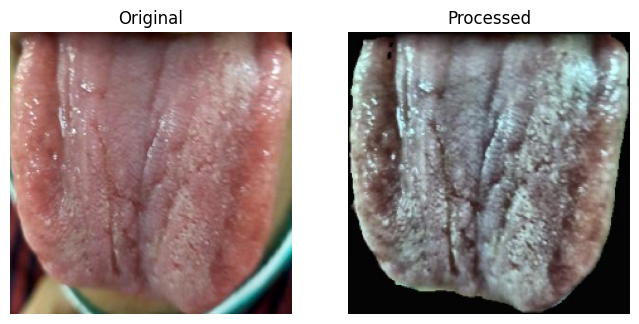

In [ ]:
import os
import random
import glob
import matplotlib.pyplot as plt
import cv2

CLASS_IMG_ROOT = "/content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped"
NEW_ROOT       = "/content/drive/MyDrive/TongueImagediabetes/data/preprocessedcropped_segpre"

def show_example(split="train", cls="diabetes"):
    # pick a random processed image (exclude coating/dist/gabor maps)
    proc_dir = os.path.join(NEW_ROOT, split, cls)
    orig_dir = os.path.join(CLASS_IMG_ROOT, split, cls)

    paths = []
    for e in ("*.png", "*.jpg", "*.jpeg", "*.bmp"):
        paths.extend(glob.glob(os.path.join(proc_dir, e)))

    # keep only files that are NOT feature maps
    paths = [
        p for p in paths
        if not any(suffix in os.path.basename(p)
                   for suffix in ("_coating", "_dist", "_gabor"))
    ]

    if not paths:
        print("No main preprocessed images found in", proc_dir)
        return

    proc_path = random.choice(paths)
    filename = os.path.basename(proc_path)
    orig_path = os.path.join(orig_dir, filename)

    print("Original :", orig_path)
    print("Processed:", proc_path)

    orig = cv2.imread(orig_path, cv2.IMREAD_COLOR)
    proc = cv2.imread(proc_path, cv2.IMREAD_COLOR)

    if orig is None or proc is None:
        print("Could not read one of the images.")
        return

    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    proc_rgb = cv2.cvtColor(proc, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1); plt.imshow(orig_rgb); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(proc_rgb); plt.title("Processed"); plt.axis("off")
    plt.show()

# example
show_example("train", "diabetes")
